<h1>Chapter 3: Classification</h3>
<h2>3.1 Introduction</h3>
<p><b>Classification</b> is a supervised ML method where the model tries to predict the correct label of a given input data. In classification, the model is fully trained using the training data, and then it is evaluated on test data before being used to perform prediction on new unseen data. </p>

<h2>3.2 MNIST</h2>
<p>We'll be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. </P>

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [3]:
X, y = mnist["data"], mnist["target"]

X.shape, y.shape

((70000, 784), (70000,))

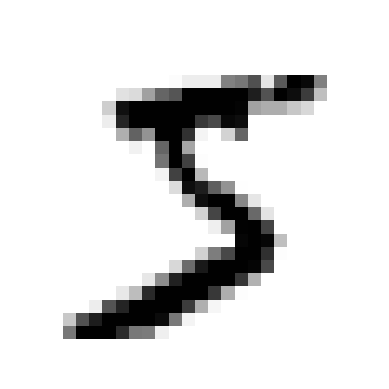

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Convert DataFrame to NumPy array if it isn't already
# Assuming `X` is a DataFrame and each row is an image in flattened form
X_np = X.to_numpy()  # Convert DataFrame to NumPy array

# Select the first image from the dataset
some_digit = X_np[0]  # Select the first row/image

# Reshape the selected image to 28x28 pixels
some_digit_image = some_digit.reshape(28, 28)

# Plot the image
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()


In [5]:
y[0]

'5'

In [6]:
import numpy as np

y = y.astype(np.uint8)

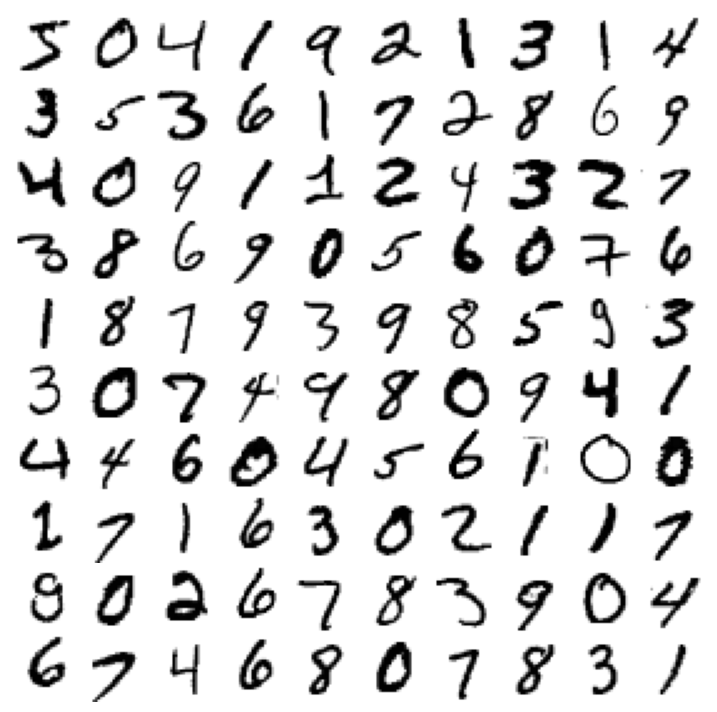

In [7]:
# Function to plot a single digit
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

# Create a figure to plot 100 digits
plt.figure(figsize=(9, 9))

# Plot the first 100 digits
for idx, image_data in enumerate(X_np[:100]):
    plt.subplot(10, 10, idx + 1)
    plot_digit(image_data)

# Adjust subplot spacing
plt.subplots_adjust(wspace=0, hspace=0)

# Show the plot
plt.show()


<p>The MNIST dataset is already split up into a training set (the first 60,000 images) and a test set (the last 10,000 images).</p>

<p>The training set is already shuffled for us, which is good because this guarantees that all cross-validation folds will be similar. Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row. </p>

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

<h2>3.3 Training a Binary Classifier</h2>
<p>First, we will only attempt to identify one digit, the number 5. This will be an example of a binary classifier.</p>

In [9]:
y_train_5 = (y_train == 5)
x_test_5 = (y_test == 5)

<p>Next, we will pick a classifier and train it. A good place to start is with a <em>Stochastic Gradient Descent</em> classifier. </p>

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [11]:
sgd_clf.predict([some_digit])

C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([ True])

<h3>3.3.1 Performance Measures</h3>
<h4>3.3.1.1 Meausring Accuracy Using Cross-Validation</h4>
<p>Let's use the cross_val_score() function to evaluate over SGDClassifier model, using K-fold cross-validation with three folds. </p>

<p>K-fold cross-valiation means splitting the training set into K folds, then making predictions and evaluating them on each fold using a model trained on the remaining folds:</p>

In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

<p>Here, we have on average over 95% accuracy on all cross-validation folds. </p>

<p>Let's look at a classifier which just classifies every single image in the "not-5" class:</p>

In [13]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    
    def predict(self, X):
        return np.zeros((len(X), 1), dtype = bool)
    
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = "accuracy")

array([0.91125, 0.90855, 0.90915])

<p>This apparaently has over 90% asccuracy. But, this is simply because only about 90% of the images are 5s, so if you always guess that an image is not 5, you will be right about 90% of the time.</p>

<p>This demonstrates why accuracy is not the preferred performance measure for classifiers, especially when you're dealing with skewed datasets. </p>

<h4>3.3.1.2 Confusion Matrix</h4>
<p>The general idea of a Confusion Matrix is to count the number of times instances of class A are classified as class B. To compute the confusion matrix, you first need to have a set of predictions os that they can be compared to the targets. </p>

In [14]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

<p>Each row in a confusion matrix represents an actual class, while each column represents a predicted class. The first row considers non-5 images (negative class), with 53k correctly classified, and 687 incorrectly classified. The second row represents 5 images, with 1k and 3k correctly and incorrectly classified. </p>

<p>The confusion matrix gives you a lot of info, but sometimes we may prefer more concise metrics. An interesting one ot look at is the accuracy of a positive prediction, called the <em>precision</em> of a classifier. </p>

<p>Precision is commonly used along with anotehr metric named <em>recall</em>, also called <em>sensitivity</em>,

<h4>3.3.1.3 Precision and Recall</h4>

In [16]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(np.float64(0.8370879772350012), np.float64(0.6511713705958311))

<p>Now, our 5-detector doesn't look so accurate after all. When it claims to represent a 5, it is correctly only 83% of the time, and it only detects 65% of the 5s. </p>

<p>It is often convenient to combine precision and recall into a single metric called the $F_{1}$ score, in particular if you need a simple way to compare two classifiers. This is the harmonic mean of the precision and recall.</p>

In [17]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

np.float64(0.7325171197343847)

<h5>3.3.1.3.1 Precision/Recall Trade-off</h5>
<p>Increasing precision reduces recall, and vice-versa. </p>

<p>To understand this trade-off, let us look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise, it assigns it to the negative class. </p>

<p>Some decision threshold is defined, which Scikit-Learn does not let you set directly, but it gives you access to the decision score that it uses to make predictions. The classifier calculates the decision score for each instance, and if the decision score is equal to or higher than the threshold value, then it predicts a positive class. If it is less, then it belongs to the negative class. </p>

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

<p>We can then see that raising the threshold decreases recall. The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 8000.</p>

<p>How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:</p>

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = "decision_function")

<p>With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds:</p>

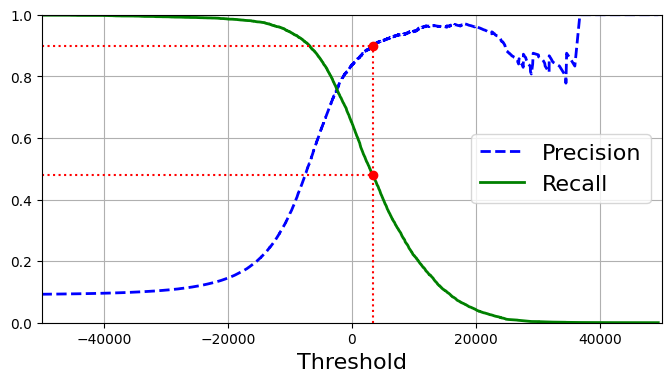

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) 
    plt.xlabel("Threshold", fontsize=16)        
    plt.grid(True)                             
    plt.axis([-50000, 50000, 0, 1])             

recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8, 4))                                                                 
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")                                             
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                                                         
plt.show()

<p>Another way to select a good precision/recall trade-off is to plot precision directly against recall, like so:</p>

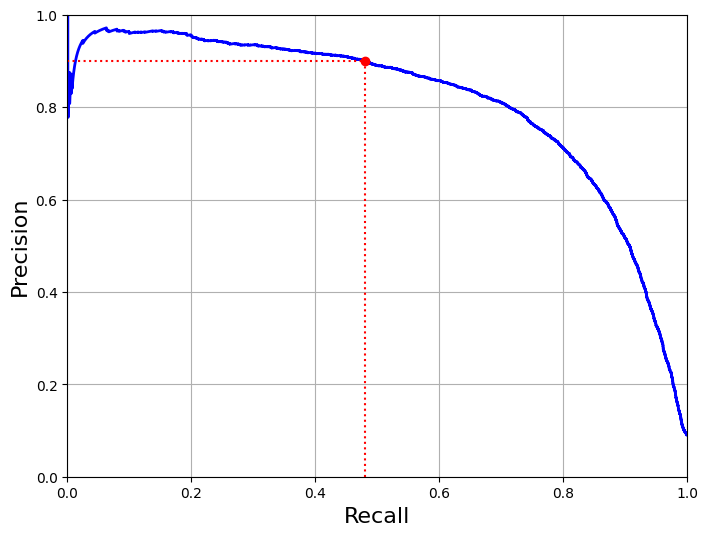

In [23]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()


<p>We can see that the precision really starts to fall sharply around 80% recall. You'd probably want to select a precision/recall trade-off just before that drop - for example, at around 60% recall. </p>

<p>Suppose you want to aim for 90% precision. We first have to search for the lowest threshold that gives you 90% precision.</p>

In [24]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

y_train_pred_90 = (y_scores >= threshold_90_precision)

precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(np.float64(0.9000345901072293), np.float64(0.4799852425751706))

<p>We can see that we can easily create a classifier with virtually any precision you want, but a high-precision classifier is not very useful if the recall is too low. </p>

<h4>3.3.1.4 The ROC Curve</h4>
<p>The receiver operator characteristic (ROC) curve is another common tool used in with binary classifiers. It plots the tru positive rate (recall) against the false positive rate (FPR). The FPR is the ratio of negative isntances that are incorrectly classified as positives, which is equal to (1-true negative rate, aka specificity). Hence, the ROC curve plots sensitivity (recall) against 1-specificity. </p>

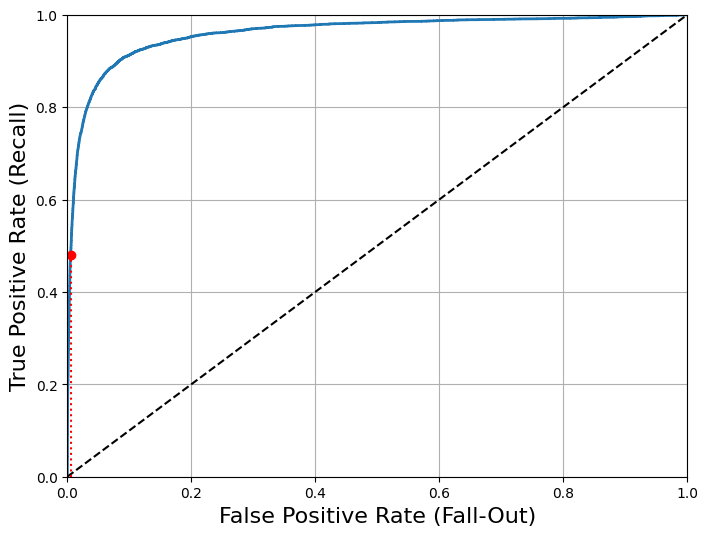

In [25]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.axis([0, 1, 0, 1])                                   
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) 
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    
    plt.grid(True)                                            

plt.figure(figsize=(8, 6))                                   
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:") 
plt.plot([fpr_90], [recall_90_precision], "ro")                                             
plt.show()

<p>Once again there is a trade off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. </p>

<p>The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible. </p>

<p>One wya to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5 </p>

In [26]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

np.float64(0.9604938554008616)

<p>We will now train a RandomForestClassifier, and compare its ROC curve and ROC AUC score with those of the SGDClassifier. </p>

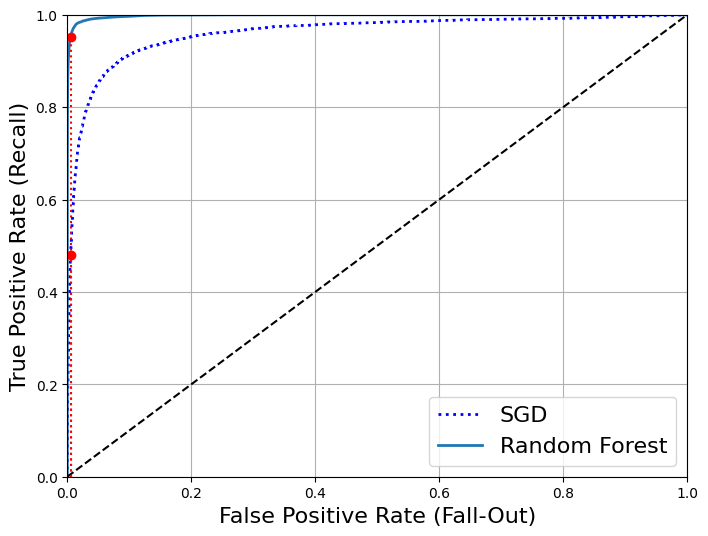

In [27]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state = 42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3, method = "predict_proba")

y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

recall_for_forest = tpr_forest[np.argmax(fpr_forest >= fpr_90)]

plt.figure(figsize = (8, 6))
plt.plot(fpr, tpr, "b:", linewidth = 2, label = "SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")
plt.plot([fpr_90], [recall_90_precision], "ro")
plt.plot([fpr_90, fpr_90], [0., recall_for_forest], "r:")
plt.plot([fpr_90], [recall_for_forest], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize = 16)
plt.show()

In [28]:
roc_auc_score(y_train_5, y_scores_forest)

np.float64(0.9983436731328145)

In [29]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv = 3)

precision_score(y_train_5, y_train_pred_forest), recall_score(y_train_5, y_train_pred_forest)

(np.float64(0.9905083315756169), np.float64(0.8662608374838591))

<p>The ROC curve looks much better for the RandomForestClassifier, the ROC AUC score is better, and the precision and recall are better. </p>

<h2>3.4 Multiclass Classification</h4>

<p>Whereas binary classifiers distinguish between two classes, <em>multiclass classifiers</em> (also called <em>multinomial classifiers</em>) can distiguish between more than two classes. </p>

<p>Some Scikit-Learn classifiers (e.g. LogisticRegression, RandomForestClassifier, and GaussianNB) are capable of handling mutliple classes natively. Others are strictly binary classifiers (e.g. SGDClassifier and SVC). There are however various strategies that you can use to perform multiclass classification with multiple binary classifiers. </p>

<p>One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (i.e. a 0-detector, 1-detector etc). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the <em>one-versus-the-rest</em> (OvR) stategy, or sometimes <em>one-versus-all</em> (OvA). </p>

<p>Another strategy is to train a binary classifier for every pair of digits: one to distinguish 0s and 1s, one to distinguish 0s and 2s, and so on. This is called the <em>one-versus-one</em> (OvO) stategy. If there are N classes, then you need to train N x (N-1)/2 classifiers. For the MNIST problem, this means training 45 binary classifiers. When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish. </p>

<p>Some algorithms (such as Support Vector Machine Classifiers) scale poorly with the size of the training set. For these algorithms, OvO is preferred because it's faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is prefferd. </p>

<p>Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. </p>


In [30]:
from sklearn.svm import SVC

svm_clf = SVC(random_state = 42)
svm_clf.fit(X_train[:2000], y_train[:2000])

SVC(random_state=42)

<p>Here, we trained the SVC using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Since there are 10 classes, Scikit-Learn used the OvO strategy and trained 45 binary classifiers. </p>

<p>We can now make a prediction on an image:</p>

In [31]:
svm_clf.predict([some_digit])

C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([5], dtype=uint8)

<p>This is the correct result. This code actually made 45 predictions - one per pair of classes - and it selected the class that won the most duels. </p>

<p>If you call the decision_function() method, you will see that it returns 10 scores per instance: one per class. Each class gets a score equal to the number of won duels plus or minus a small tweak (max ± 0.33) to break ties, based on the classifer scores:</p>

In [32]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

<p>The highest score is 9.3, and it's indeed the one corresponding to class 5:</p>

In [33]:
class_id = some_digit_scores.argmax()
class_id

np.int64(5)

<p>When a classifier is trained, it scores the list of target classes in its classes_ attribute, orded by value. In the case of MNIST, the index of each class in the classes_ array matches the class itself, but that is obviously not generally the case. </p>

In [34]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [35]:
svm_clf.classes_[class_id]

np.uint8(5)

<p>If you want to force Scikit-Learn to use OvO or OvR, you can use the OneVsOneClassifer or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor. </p>

In [36]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(random_state = 42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [37]:
ovr_clf.predict([some_digit])

C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but

array([5], dtype=uint8)

In [38]:
len(ovr_clf.estimators_)

10

<p>Training an SGDClassifier on a multiclass dataset and using it to make predictions is just as easy:</p>

In [39]:
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([3], dtype=uint8)

<p>We know that this is, however, incorrect. </p>

<p>This time, Scikit-Learn used the OvR strategy under the hood: since there are 10 classes, it trained 10 binary classifiers. The decision_function() method now returns one value per class. </p>

<p>Let's look at the scores that the SGD classifier assigns to each class: </p>

In [40]:
sgd_clf.decision_function([some_digit]).round()

C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but SGDClassifier was fitted with feature names
  warnings.warn(


array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

<p>We see here that the classifier is not very confident in its predictions: almost all scores are very negative, which class 3 has a score of +1825, and class 5 is not too far behind, with a score of -1386. </p>

<p>Of course, we will want to evaluate this classifier on more than one image. Since there are roughly the same amount of images in each class, the accuracy metric is fine. </p>

<p>As usual, we can use the cross_val_score() function to evaluate the model:</p>

In [41]:
cross_val_score(sgd_clf, X_train, y_train, cv = 3, scoring = "accuracy")

array([0.87365, 0.85835, 0.8689 ])

<p>It gets over 85% accuracy on all test folds. If you use a random classifier, you would get 10% accuracy, so this isn't a bad score, but we can obviously do much better. </p>

<p>Simply scaling the inputs increases the accuracy:</p>

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train.astype("float64"))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring = "accuracy")

array([0.8983, 0.891 , 0.9018])

<h2>3.5 Error Analysis</h2>
<p>We will assume that we have found a promising model (i.e. skip the rest of the steps in the ML project checklist), and we are looking for ways to improve it. One way to do this, is to analyse the types of errors it makes. </p>

<p>First, we look at the confusion matrix. For this, we need to first make predictions using the cross_val_predict() function, then we pass the labels and predictions to the confusion_matrix() function. </p>

<p>However, since there are 10 classes instead of 2, the confusion matrix will contain quite a lot of numbers, and it may be hard to read. A coloured diagram of the confusion matrix is much easier to analyse. To plot such a diagram, we can use the ConfusionMatrixDisplay function like this:</p>

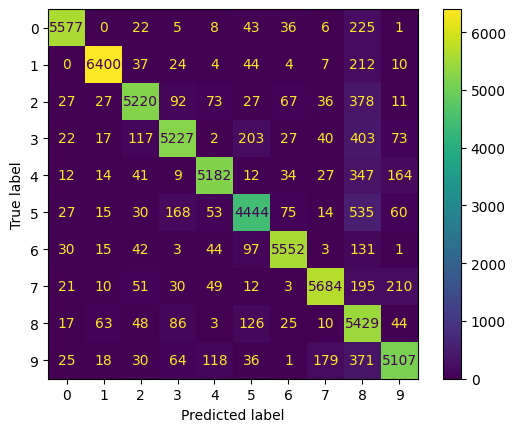

In [43]:
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred)
plt.show()

<p>Most images are on the main diagonal, which means that they were classified correctly.</p>

<p>Notice that the (5, 5) cell looks slightly darker than the other digits. This could be because the model made more errors on 5s, or because there are fewer 5s in the dataset than other digits. This is why it is important to normalise the confusion matrix, by dividing each value by the total number of images in the corresponding (true) class (i.e. divide by the row's sum). </p>

<p>This can be done by setting normalize="true". We can also specify the values_format=".0%" argument to show percentages with no decimals.</p>

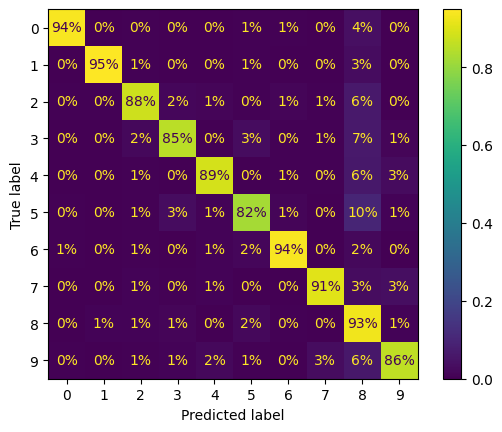

In [44]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize = "true", values_format = ".0%")
plt.show()

<p>We can easily see that only 82% of the images of 5s were correctly classified, and that the model commonly mistook 5s for 8s.</p>

<p>If we want to make the errors stand out more, we can try putting zero weight on the correct predictions:</p>

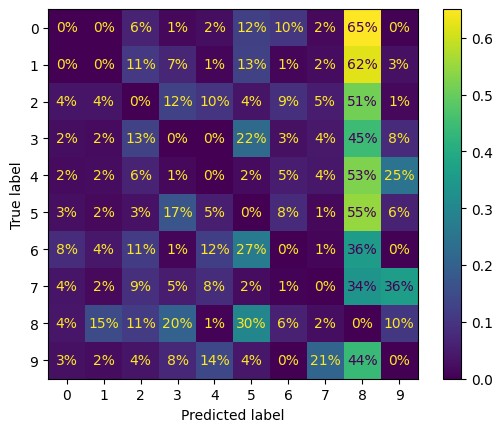

In [45]:
sample_weight = (y_train_pred != y_train)

ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, 
                                        sample_weight = sample_weight,
                                          normalize = "true", values_format = ".0%")

<p>Analysing the confusion matrix often gives you insights into ways to improve your classifier. Looking at these plots, it seems that your efforts should be spent on reducing the false 8s. For example, you could try to geather more training data for digits that look like 8s (but aren't), so that the classifier can learn to distinguish them from real 8s.</p>

<p>You could also engineer new features that would help the classifier - for example, writing an algorithm to count the number of closed loops (e.g. 8 has two, 6 has one, 5 has none). </p>

<h2>3.6 Multilabel Classification</h2>
<p>Until now, each instance has always been assigned to just one class. But in some cases you may want your classifier to output multiple classes for each instance. This is known as a <em>multilabel classification</em> system. </p>

In [46]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train.astype('int8') >= 7)
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier()

<p>This code creates a y_multilabel array containing two target labels for each digit image: the first indicates whether or not the digit is large (7, 8, or 9), and the second indicates whether or not it is odd. Then the code creates a KNeighborsClassifier instance, which supports multilabel classification, and trains this model using the multiple targets array. </p>

<p>Now, you can make a prediction, and notice that it outputs two labels:</p>

In [47]:
knn_clf.predict([some_digit])

C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


array([[False,  True]])

<p>This is correct. The digit 5 is indeed not large (False) and odd (True). </p>

<p>There are many ways to evaluate a multilabel classifier, and selecting the right metric really depends on the project. One approach is to measure the $F_{1}$ score for each individual label (or any binary classifier metric), then simply compute the average score. </p>

In [48]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv = 3)
f1_score(y_multilabel, y_train_knn_pred, average = "macro")

np.float64(0.9764102655606048)

<p>This approach assumes that all labels are equally important, which may not be the case. In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier's score on pictures of Alice. One simple option is to give each label a weight equal to its <em>support</em> (i.e. the number of instances with that target label). To do this, we simply set average="weighted" when calling the f1_score() function. </p>

<p>If you wish to use a classifier which doesn't natively support multilabel classification, such as SVC, one possible strategy is to train one model per label. However, this strategy may have a hard time capturing the dependencies between labels. For example, a large digit (7, 8, or 9) is twice more likely to be odd than even, but the classifier for the "odd" label doesn't know what the classifier for the "large" label predicted. </p>

<p>To solve this proble, the models can be organised in a chain: when a model makes a prediction, it uses the input features plus all the predictions of the models that come before it in the chain. This is built into ChainClassifier in Scikit-Learn. By default, it will use the true labels for training, feeding each model the appropriate labels depending on their position in the chain. But, if you set the cv hyperparameter, it will use cross-validation to get "clean" (out-of-sample) predictions from each trained model for every instance in the training set, and these predictions will then be used to train all the models later in the chain. </p?

In [50]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv = 3, random_state = 42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

ClassifierChain(base_estimator=SVC(), cv=3, random_state=42)

<h2>3.7 Multioutput Classification</h2>
<p>The last type of classification task to discuss is called <em>multiclass classification</em> (or just multioutput classification). It is a generalisation of multilabel classification where each label can be multiclass (i.e. it can have more than two possible values). </p>

<p>To do this, we will build a system that removes noise from images. It will take as input a noisy digit image, and it will output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. </p>

<p>Notice that the classifier's output is multilabel (one label per pixel) and each label can have multiple values (pixel intensities range from 0 to 256). This is thus an example of a multioutput classification system. </p>

<p>Let's start by creaing the training and tests sets by taking the MNIST images and adding noise to their pixel intensities:</p>

In [53]:
import numpy as np

# Seed for reproducibility
np.random.seed(42)

# Adding noise to the training data
noise_train = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise_train

# Adding noise to the test data
noise_test = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise_test

# Setting y_train_mod and y_test_mod to be the original datasets (before noise)
y_train_mod = X_train.copy()
y_test_mod = X_test.copy()


<p>Let's take a look at the first image from the test set. </p>

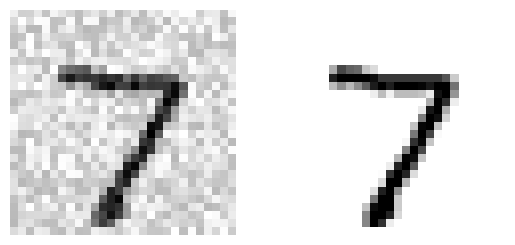

In [56]:
X_test_mod = X_test_mod.to_numpy()
y_test_mod = y_test_mod.to_numpy()

some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

C:\Users\Lee\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


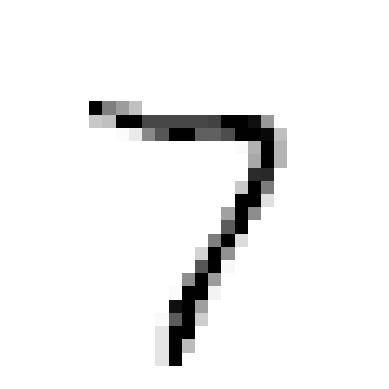

In [57]:
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[0]])
plot_digit(clean_digit)
plt.show()

<p>This aligns with the target. </p>